# Check perturbation experiment output

plot differences in ustar, ssh, 

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [27]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Set model paths

In [4]:
base = '/archive/Marion.Alberty/FMS2021.02_mom6_20210630/'
hist = 'gfdl.ncrc4-intel18-prod/history/19580101.ocean_Bering_Strait.nc'

In [5]:
# output
path_ctrl = base + 'OM4p25_JRA55do1.4_r6_BeringWindPert_control/' + hist
path_v0 = base + 'OM4p25_JRA55do1.4_r6_BeringWindPert_Lx100_Ly500_tau28_v0/' + hist
path_v5 = base + 'OM4p25_JRA55do1.4_r6_BeringWindPert_Lx100_Ly500_tau28_v5/' + hist
path_v10 = base + 'OM4p25_JRA55do1.4_r6_BeringWindPert_Lx100_Ly500_tau28_v10/' + hist
path_v20 = base + 'OM4p25_JRA55do1.4_r6_BeringWindPert_Lx100_Ly500_tau28_v20/' + hist

## Read in model data

In [6]:
def open_model_data(flist):
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    # Clean up coordinate names
    crds2chng = [match for match in list(DS.coords) if "_sub01" in match]
    for i in crds2chng:
        DS = DS.rename_dims({i:i[:2]}).rename({i:i[:2]})
    
    # Clean up variables with duplicate coords
    if "xh_sub02" in list(DS.coords):
        DS = DS.assign_coords(xh=("xh_sub02", DS.xh)).swap_dims({"xh_sub02": "xh"})
        DS = DS.drop_vars('xh_sub02')
    
    # Deal with padded zeros in xh
    if 'xh' in list(DS.coords):
        DS = DS.where(DS.xh!=0,drop=True)
        
    return DS.squeeze()

In [31]:
DS_ctrl = open_model_data(path_ctrl)
DS_v0 = open_model_data(path_v0)
DS_v5 = open_model_data(path_v5)
DS_v10 = open_model_data(path_v10)
DS_v20 = open_model_data(path_v20)

## Make some simple plots of departures from the control

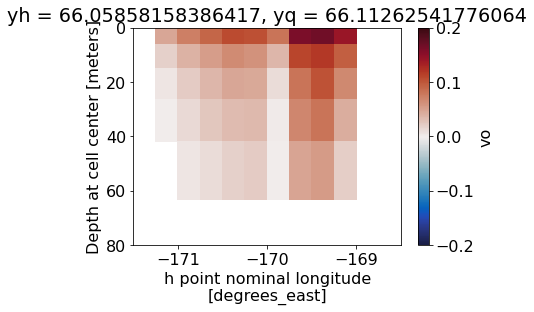

In [53]:
(DS_v10['vo'].mean('time') - DS_ctrl['vo'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-0.2,vmax=0.2)
plt.ylim(80,0)
plt.show()

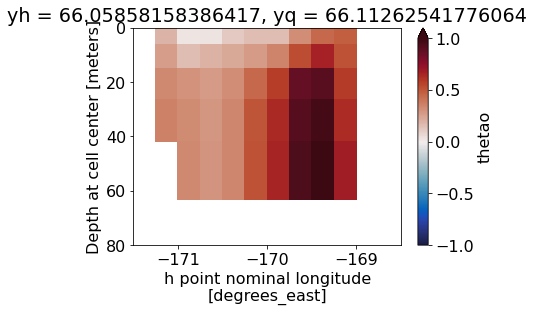

In [33]:
(DS_v10['thetao'].mean('time') - DS_ctrl['thetao'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-1,vmax=1)
plt.ylim(80,0)
plt.show()

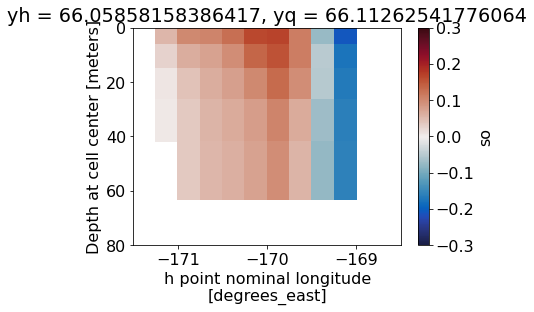

In [52]:
(DS_v10['so'].mean('time') - DS_ctrl['so'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-0.3,vmax=0.3)
plt.ylim(80,0)
plt.show()

## Look at transport differences

In [37]:
rho_0 = 1035

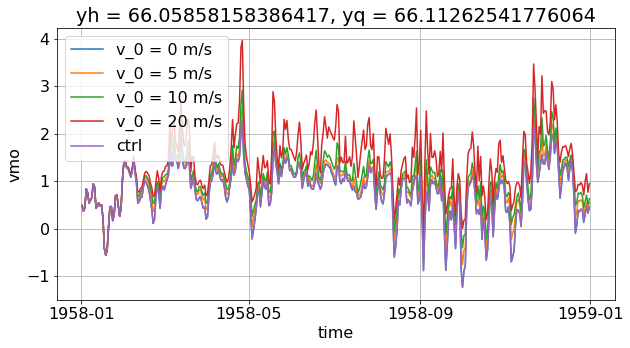

In [38]:
fig = plt.figure(figsize=(10,5))
(DS_v0['vmo'].sum(['xh','z_l'])/rho_0*(10**-6)).plot(label='v_0 = 0 m/s')
(DS_v5['vmo'].sum(['xh','z_l'])/rho_0*(10**-6)).plot(label='v_0 = 5 m/s')
(DS_v10['vmo'].sum(['xh','z_l'])/rho_0*(10**-6)).plot(label='v_0 = 10 m/s')
(DS_v20['vmo'].sum(['xh','z_l'])/rho_0*(10**-6)).plot(label='v_0 = 20 m/s')
(DS_ctrl['vmo'].sum(['xh','z_l'])/rho_0*(10**-6)).plot(label='ctrl')
plt.legend()
plt.grid()
plt.show()

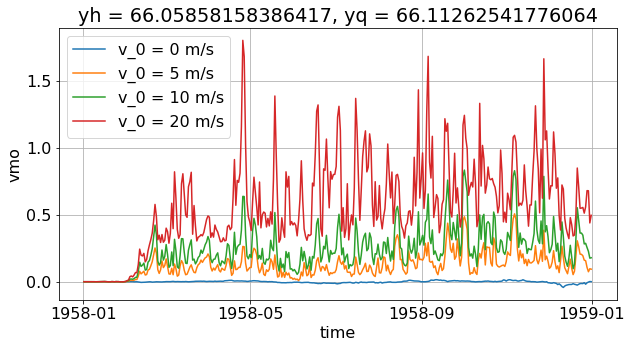

In [39]:
fig = plt.figure(figsize=(10,5))
((DS_v0['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l']))/rho_0*(10**-6)).plot(label='v_0 = 0 m/s')
((DS_v5['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l']))/rho_0*(10**-6)).plot(label='v_0 = 5 m/s')
((DS_v10['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l']))/rho_0*(10**-6)).plot(label='v_0 = 10 m/s')
((DS_v20['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l']))/rho_0*(10**-6)).plot(label='v_0 = 20 m/s')
plt.legend()
plt.grid()
plt.show()

## Compare time average of response to forcing strength

In [17]:
def mean_transport_response(DS):
    T_bar = (DS['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l'])
            ).sel(time=slice('1958-04-01',None)).mean('time')/rho_0*(10**-6)
    return T_bar.values

In [40]:
T_v0 = mean_transport_response(DS_v0)
T_v5 = mean_transport_response(DS_v5)
T_v10 = mean_transport_response(DS_v10)
T_v20 = mean_transport_response(DS_v20)

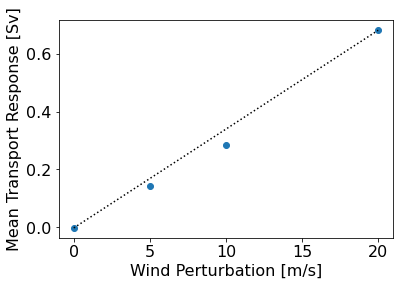

In [43]:
plt.scatter([0, 5, 10, 20],[T_v0, T_v5, T_v10, T_v20])
plt.plot([0, 20],[T_v0, T_v20],':k')
plt.ylabel('Mean Transport Response [Sv]')
plt.xlabel('Wind Perturbation [m/s]')
plt.show()